# Premier League Engine Evaluation

***
#### Importing Dependencies

In [1]:
# Importing Dependencies
from statsmodels.stats.outliers_influence import variance_inflation_factor as VIF
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn import set_config
from sklearn.metrics import *

import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import warnings
import pickle
import yaml
import os

In [2]:
sns.set(font_scale = 1.2, style = 'darkgrid', palette = 'bright')
warnings.filterwarnings(action = 'ignore')
plt.rcParams['figure.figsize'] = (12, 8)
pd.options.display.max_columns = None
set_config(display = 'diagram')
np.random.seed(seed = 42)

Let's define a function to load a yaml file.

In [3]:
# Defining a function to load a yaml file
def load_yaml(filepath = None):
    """
    This is a function that will load a yaml file.
    
    Args:
        filepath: A path to a yaml file.
        
    Returns:
        A dictionary object.
    """
    # Loading the yaml file
    with open(file = filepath) as yaml_file:
        config = yaml.safe_load(stream = yaml_file)
    
    # Returning the yaml file
    return config

Let's load the yaml file and create global variables.

In [4]:
# Loading model properties from a yaml file
CONFIG = load_yaml(filepath = '/Users/kzeynalzade/Documents/Project/Configuration/config.yml')

# Creating a path to datasets
TARGET_PATH = '/Users/kzeynalzade/Documents/Project/Data/Converted data'

# Loading features for a batch model from model properties
FEATURES = CONFIG.get('features').get('batch_model_features')

# Extracting the path for the Loss model 
LOSS_MODEL_PATH = CONFIG.get('models_paths').get('loss_model_path')

# Extracting the path for the Draw model 
DRAW_MODEL_PATH = CONFIG.get('models_paths').get('draw_model_path')

# Extracting the path for the Win model 
WIN_MODEL_PATH = CONFIG.get('models_paths').get('win_model_path')

# Extracting the path for the Loss model 
SHADOW_LOSS_MODEL_PATH = CONFIG.get('shadow_models_paths').get('shadow_loss_model_path')

# Extracting the path for the Draw model 
SHADOW_DRAW_MODEL_PATH = CONFIG.get('shadow_models_paths').get('shadow_draw_model_path')

# Extracting the path for the Win model 
SHADOW_WIN_MODEL_PATH = CONFIG.get('shadow_models_paths').get('shadow_win_model_path')

# Loading the dependent variable for Loss modeling
LOSS_TARGET = CONFIG.get('target').get('loss_model')

# Loading the dependent variable for Draw modeling
DRAW_TARGET = CONFIG.get('target').get('draw_model')

# Loading the dependent variable for Win modeling
WIN_TARGET = CONFIG.get('target').get('win_model')

# Loading the current season
CURRENT_SEASON = CONFIG.get('current_season')

Let's define a custom preprocessor that reallocates features.

In [5]:
# Defining a custom transformer to reallocate variables
class FeatureReallocator(BaseEstimator, TransformerMixin):
    # Defining a function for fitting data to custom transformer
    def fit(self, X, y = None):
        # Creating a list of binary features
        binary_features = [feature for feature in FEATURES if X[feature].nunique() == 2]

        # Creating a list of date features
        date_features = ['match_week', 'month', 'day', 'weekday']

        # Creating a list of ordinal features
        ordinal_features = ['h_position', 'a_position']

        # Creating a list of numeric features
        left_out_features = [feature for feature in X.columns.tolist() if feature not in binary_features + date_features + ordinal_features]

        # Creating a list of reallocated features
        reallocated_features = date_features + ordinal_features + left_out_features + binary_features
        
        # Defining the list for feature reallocation
        self.reallocated_features = reallocated_features
        
        # Defining the list for ordinal features
        self.ordinal_features = ordinal_features
        
        # Returning the fitted and transformed data
        return self
    
    # Defining a function for transforming data with custom transformer
    def transform(self, X, y = None):
        # Reallocating variables
        X = X[[feature for feature in self.reallocated_features if feature in FEATURES]]
        
        # Converting the values of ordinal variables into string
        X[self.ordinal_features] = X[self.ordinal_features].applymap(func = lambda x: str(x))
        
        # Returning the transformed data
        return X

Let's define a customer preprocessor that drops features with high **VIF** values.

In [6]:
# Defining a custom transformer to remove multicollinearity
class VifDropper(BaseEstimator, TransformerMixin):
    # Initializing the default threshold for variance inflation factor (VIF)
    def __init__(self, threshold = 2.5):
        # Default VIF threshold
        self.threshold = threshold

    # Defining a function for fitting data to custom transformer
    def fit(self, X, y = None):
        # Creating a copy of a Numpy array as Pandas dataframe
        data = pd.DataFrame(data = X).copy()
        
        # Creating a Pandas dataframe
        vif_df = pd.DataFrame()
        
        # Assigning the names of columns to a feature variable
        vif_df['feature'] = data.columns
        
        # Calculating VIF values
        vif_df['VIF'] = [VIF(exog = data.values, exog_idx = i) for i in range(len(data.columns))]
        
        # Creating an empty list
        features_with_max_vif = []
        
        # Calculating VIF values of variables based on default threshold
        while vif_df.VIF.max() > self.threshold:
            feature_with_max_vif = vif_df.loc[vif_df.VIF == vif_df.VIF.max()].feature.values[0]
            data.drop(columns = feature_with_max_vif, inplace = True)
            features_with_max_vif.append(feature_with_max_vif)
 
            vif_df = pd.DataFrame()
            vif_df['feature'] = data.columns
            vif_df['VIF'] = [VIF(exog = data.values, exog_idx = i) for i in range(len(data.columns))]
        
        # Defining the list of variables with maximum VIF values
        self.features_with_max_vif = features_with_max_vif
        
        # Returning the fitted and transformed data
        return self 
    
    # Defining a function for transforming data with custom transformer
    def transform(self, X, y = None):
        # Returning the transformed data
        return pd.DataFrame(data = X).drop(columns = self.features_with_max_vif).values

Let's load the models.

In [7]:
# Loading the Loss model
with open(file = LOSS_MODEL_PATH, mode = 'rb') as pickled_model:
    loss_model = pickle.load(file = pickled_model)

# Loading the Draw model
with open(file = DRAW_MODEL_PATH, mode = 'rb') as pickled_model:
    draw_model = pickle.load(file = pickled_model)

# Loading the Win model
with open(file = WIN_MODEL_PATH, mode = 'rb') as pickled_model:
    win_model = pickle.load(file = pickled_model)
    
# Loading the Shadow Loss model
with open(file = SHADOW_LOSS_MODEL_PATH, mode = 'rb') as pickled_model:
    shadow_loss_model = pickle.load(file = pickled_model)

# Loading the Shadow Draw model
with open(file = SHADOW_DRAW_MODEL_PATH, mode = 'rb') as pickled_model:
    shadow_draw_model = pickle.load(file = pickled_model)

# Loading the Shadow Win model
with open(file = SHADOW_WIN_MODEL_PATH, mode = 'rb') as pickled_model:
    shadow_win_model = pickle.load(file = pickled_model)

Let's define a function to load the dataset.

In [8]:
# Defining a function to load the dataset
def load_data(target_path = None, non_na_ratio = 0.6):
    """
    This is a function that is used to load datasets from a specified path and create a cohesive dataset.
    
    Args:
        target_path: A path for the datasets.
        non_na_ratio: A non na ratio for variables.
        
    Returns:
        A pandas data frame.
    """
    # Creating a list of datasets based on the specified path
    datasets = [f'{target_path}/{file}' for file in os.listdir(path = target_path) if file.endswith('.brotli')]
    
    # Loading the datasets using list comprehension
    data_frames = [pd.read_parquet(path = dataset, engine = 'fastparquet') for dataset in datasets]
    
    # Concatenating data frames to create a cohesive data frame
    data_frame = pd.concat(objs = data_frames, ignore_index = True)
    
    # Casting the data type of the match date variable from object to datetime
    data_frame.match_date = pd.to_datetime(arg = data_frame.match_date, yearfirst = True)
    
    # Sorting the observations based on match_date variable in ascending order
    data_frame.sort_values(by = 'match_date', inplace = True)
    
    # Reseting the index to maintain index order
    data_frame.reset_index(drop = True, inplace = True)
    
    # Removing potential duplicate observations
    data_frame.drop_duplicates(inplace = True, ignore_index = True)
    
    # Dropping features that exceed non na ratio
    data_frame.dropna(axis = 1, thresh = int(data_frame.shape[0] * non_na_ratio), inplace = True)
    
    # Returning the data frame
    return data_frame

Let's load the data, add feature indicators, and create training data for each model.

In [9]:
# Calling the function to load the dataset
df = load_data(target_path = TARGET_PATH)

# Displaying the first five records
df.head()

,season,match_week,match_date,month,day,weekday,referee,home_team,away_team,stadium,attendance,h_position,a_position,goals_h,goals_a,possession_h,possession_a,shots_on_target_h,shots_on_target_a,shots_h,shots_a,touches_h,touches_a,passes_h,passes_a,tackles_h,tackles_a,clearances_h,clearances_a,corners_h,corners_a,offsides_h,offsides_a,yellow_cards_h,yellow_cards_a,red_cards_h,red_cards_a,fouls_conceded_h,fouls_conceded_a,formation_h,formation_a,result_h,result_a,points_h,points_a,total_n_matches_played_h,total_n_matches_played_a,total_max_points_h,total_max_points_a,total_points_h_cum,total_points_a_cum,total_points_dropped_h,total_points_dropped_a,total_goals_scored_h,total_goals_scored_a,total_goals_conceded_h,total_goals_conceded_a,total_avg_possession_h,total_avg_possession_a,total_avg_possession_last_3_h,total_avg_possession_last_3_a,total_avg_possession_last_5_h,total_avg_possession_last_5_a,total_avg_shots_on_target_h,total_avg_shots_on_target_a,total_avg_shots_on_target_last_3_h,total_avg_shots_on_target_last_3_a,total_avg_shots_on_target_last_5_h,total_avg_shots_on_target_last_5_a,total_avg_shots_h,total_avg_shots_a,total_avg_shots_last_3_h,total_avg_shots_last_3_a,total_avg_shots_last_5_h,total_avg_shots_last_5_a,total_avg_touches_h,total_avg_touches_a,total_avg_touches_last_3_h,total_avg_touches_last_3_a,total_avg_touches_last_5_h,total_avg_touches_last_5_a,total_avg_passes_h,total_avg_passes_a,total_avg_passes_last_3_h,total_avg_passes_last_3_a,total_avg_passes_last_5_h,total_avg_passes_last_5_a,total_avg_tackles_h,total_avg_tackles_a,total_avg_tackles_last_3_h,total_avg_tackles_last_3_a,total_avg_tackles_last_5_h,total_avg_tackles_last_5_a,total_avg_clearances_h,total_avg_clearances_a,total_avg_clearances_last_3_h,total_avg_clearances_last_3_a,total_avg_clearances_last_5_h,total_avg_clearances_last_5_a,total_avg_corners_h,total_avg_corners_a,total_avg_corners_last_3_h,total_avg_corners_last_3_a,total_avg_corners_last_5_h,total_avg_corners_last_5_a,total_avg_offsides_h,total_avg_offsides_a,total_avg_offsides_last_3_h,total_avg_offsides_last_3_a,total_avg_offsides_last_5_h,total_avg_offsides_last_5_a,total_avg_yellow_cards_h,total_avg_yellow_cards_a,total_avg_yellow_cards_last_3_h,total_avg_yellow_cards_last_3_a,total_avg_yellow_cards_last_5_h,total_avg_yellow_cards_last_5_a,total_avg_fouls_conceded_h,total_avg_fouls_conceded_a,total_avg_fouls_conceded_last_3_h,total_avg_fouls_conceded_last_3_a,total_avg_fouls_conceded_last_5_h,total_avg_fouls_conceded_last_5_a,n_matches_played_h,n_matches_played_a,max_points_h,max_points_a,points_h_cum,points_a_cum,points_dropped_h,points_dropped_a,goals_scored_h_cum,goals_scored_a_cum,goals_conceded_h_cum,goals_conceded_a_cum,avg_possession_h,avg_possession_a,avg_possession_last_3_h,avg_possession_last_3_a,avg_possession_last_5_h,avg_possession_last_5_a,avg_shots_on_target_h,avg_shots_on_target_a,avg_shots_on_target_last_3_h,avg_shots_on_target_last_3_a,avg_shots_on_target_last_5_h,avg_shots_on_target_last_5_a,avg_shots_h,avg_shots_a,avg_shots_last_3_h,avg_shots_last_3_a,avg_shots_last_5_h,avg_shots_last_5_a,avg_touches_h,avg_touches_a,avg_touches_last_3_h,avg_touches_last_3_a,avg_touches_last_5_h,avg_touches_last_5_a,avg_passes_h,avg_passes_a,avg_passes_last_3_h,avg_passes_last_3_a,avg_passes_last_5_h,avg_passes_last_5_a,avg_tackles_h,avg_tackles_a,avg_tackles_last_3_h,avg_tackles_last_3_a,avg_tackles_last_5_h,avg_tackles_last_5_a,avg_clearances_h,avg_clearances_a,avg_clearances_last_3_h,avg_clearances_last_3_a,avg_clearances_last_5_h,avg_clearances_last_5_a,avg_corners_h,avg_corners_a,avg_corners_last_3_h,avg_corners_last_3_a,avg_corners_last_5_h,avg_corners_last_5_a,avg_offsides_h,avg_offsides_a,avg_offsides_last_3_h,avg_offsides_last_3_a,avg_offsides_last_5_h,avg_offsides_last_5_a,avg_yellow_cards_h,avg_yellow_cards_a,avg_yellow_cards_last_3_h,avg_yellow_cards_last_3_a,avg_yellow_cards_last_5_h,avg_yellow_cards_last_5_a,avg_fouls_conceded_h,avg_fouls_conceded_a,avg_fouls_conce

In [10]:
def make_predictions(data_frame = None, use_shadow_models = False):
    # Creating a list of class labels 
    class_labels = [-1, 0, 1]
    
    # Creating an input data for the Loss model
    loss_data = data_frame.drop(columns = LOSS_TARGET)

    # Creating an input data for the Draw model
    draw_data = data_frame.drop(columns = DRAW_TARGET)

    # Creating an input data for the Win model
    win_data = data_frame.drop(columns = WIN_TARGET)
    
    if not use_shadow_models:
        # Calculating the probabilities for the positive class of the Loss model
        loss_probabilities = np.expand_dims(a = loss_model.predict_proba(X = loss_data)[:, 1], axis = 1)

        # Calculating the probabilities for the positive class of the Draw model
        draw_probabilities = np.expand_dims(a = draw_model.predict_proba(X = draw_data)[:, 1], axis = 1)

        # Calculating the probabilities for the positive class of the Win model
        win_probabilities = np.expand_dims(a = win_model.predict_proba(X = win_data)[:, 1], axis = 1)
    else:
        # Calculating the probabilities for the positive class of the Shadow Loss model
        loss_probabilities = np.expand_dims(a = shadow_loss_model.predict_proba(X = loss_data)[:, 1], axis = 1)

        # Calculating the probabilities for the positive class of the Shadow Draw model
        draw_probabilities = np.expand_dims(a = shadow_draw_model.predict_proba(X = draw_data)[:, 1], axis = 1)

        # Calculating the probabilities for the positive class of the Shadow Win model
        win_probabilities = np.expand_dims(a = shadow_win_model.predict_proba(X = win_data)[:, 1], axis = 1)
    
    # Creating an array of probabilities of each model
    probabilities = np.hstack(tup = (loss_probabilities, draw_probabilities, win_probabilities))
    
    # Creating a list of predictions based on maximum probability index
    prediction = [class_labels[class_label] for class_label in probabilities.argmax(axis = 1)]
    
    # Extracting the probability for the prediction 
    probability = [probas[probas.argmax()] for probas in probabilities]
    
    # Using the Loss model to make predictions
    loss_predictions = loss_model.predict(X = loss_data)
    
    # Using the Draw model to make predictions
    draw_predictions = draw_model.predict(X = draw_data)
    
    # Using the Win model to make predictions
    win_predictions = win_model.predict(X = win_data)
    
    # Assigning engine predictions to prediction column
    data_frame['prediction'] = prediction
    
    # Assigning engine probabilities to probability column
    data_frame['probability'] = probability
    
    # Assigning the Win model predictions to home_prediction column
    data_frame['home_prediction'] = win_predictions
    
    # Assigning the Loss model predictions to away_prediction column
    data_frame['away_prediction'] = loss_predictions
    
    # Assigning the Draw model predictions to draw_predictions column
    data_frame['draw_prediction'] = draw_predictions
    
    data_frame['engine_output'] = ''
    
    # Creating a confidence interval variable
    data_frame['confidence'] = ''
    
    # Creating a bet making variable
    data_frame['bet'] = False
    
    # Creating confidence interval boundaries
    data_frame.loc[data_frame.probability < 0.35, 'confidence'] = 'Very Low'
    data_frame.loc[data_frame.probability.between(left = 0.35, right = 0.55, inclusive = 'left'), 'confidence'] = 'Low'
    data_frame.loc[data_frame.probability.between(left = 0.55, right = 0.65, inclusive = 'left'), 'confidence'] = 'Medium'
    data_frame.loc[data_frame.probability.between(left = 0.65, right = 0.85, inclusive = 'left'), 'confidence'] = 'High'
    data_frame.loc[data_frame.probability >= 0.85, 'confidence'] = 'Very High'
    
    # Assigning a positive boolean value to matches where engine suggests to make a bet
    data_frame.loc[data_frame.confidence.isin(values = ['High', 'Very High']), 'bet'] = True
    
    # Engine output message for victories
    win_output = data_frame.loc[data_frame.prediction == 1][['home_team', 'away_team', 'probability']].\
    apply(func = lambda x: f'Probability of {x[0]} beating {x[1]} at home is {x[-1]:.0%}.', axis = 1)
    
    # Engine output message for defeats
    loss_output = data_frame.loc[data_frame.prediction == -1][['home_team', 'away_team', 'probability']].\
    apply(func = lambda x: f'Probability of {x[1]} defeating {x[0]} away from home is {x[-1]:.0%}.', axis = 1)
    
    # Engine output message for draws
    draw_output = data_frame.loc[data_frame.prediction == 0][['home_team', 'away_team', 'probability']].\
    apply(func = lambda x: f'Probability of {x[0]} and {x[1]} sharing points is {x[-1]:.0%}.', axis = 1)
    
    # Assigning the engine output messages to engine_output column
    data_frame.loc[data_frame.prediction == 1, 'engine_output'] = win_output
    data_frame.loc[data_frame.prediction == -1, 'engine_output'] = loss_output
    data_frame.loc[data_frame.prediction == 0, 'engine_output'] = draw_output
    
    # Creating a list of output columns
    output_columns = ['season', 'match_week', 'match_date', 'home_team', 'away_team', 'home_win', 'home_prediction', 'away_win', 'away_prediction', 
                      'draw', 'draw_prediction', 'ground_truth', 'prediction', 'probability', 'confidence', 'bet', 'engine_output']
    
    # Sorting matches based on match date in descending order
    data_frame = data_frame[output_columns].sort_values(by = 'match_date', ascending = False).reset_index(drop = True)
    
    # Returning the data frame
    return data_frame

In [11]:
# Calling the function to make predictions
results_df = make_predictions(data_frame = df)

# Displaying the first five records
results_df.head()

,season,match_week,match_date,home_team,away_team,home_win,home_prediction,away_win,away_prediction,draw,draw_prediction,ground_truth,prediction,probability,confidence,bet,engine_output
0,2022/23,11,2022-10-16,Aston Villa,Chelsea,0,0,1,1,0,0,-1,-1,0.643767,Medium,False,Probability of Chelsea defeating Aston Villa a...
1,2022/23,11,2022-10-16,Leeds,Arsenal,0,0,1,1,0,0,-1,-1,0.655744,High,True,Probability of Arsenal defeating Leeds away fr...
2,2022/23,11,2022-10-16,Man Utd,Newcastle,0,0,0,0,1,0,0,1,0.500000,Low,False,Probability of Man Utd beating Newcastle at ho...
3,2022/23,11,2022-10-16,Southampton,West Ham,0,0,0,0,1,0,0,1,0.295568,Very Low,False,Probability of Southampton beating West Ham at...
4,2022/23,11,2022-10-16,Liverpool,Man City,1,0,0,0,0,0,1,1,0.500000,Low,False,Probability of Liverpool beating Man City at h...


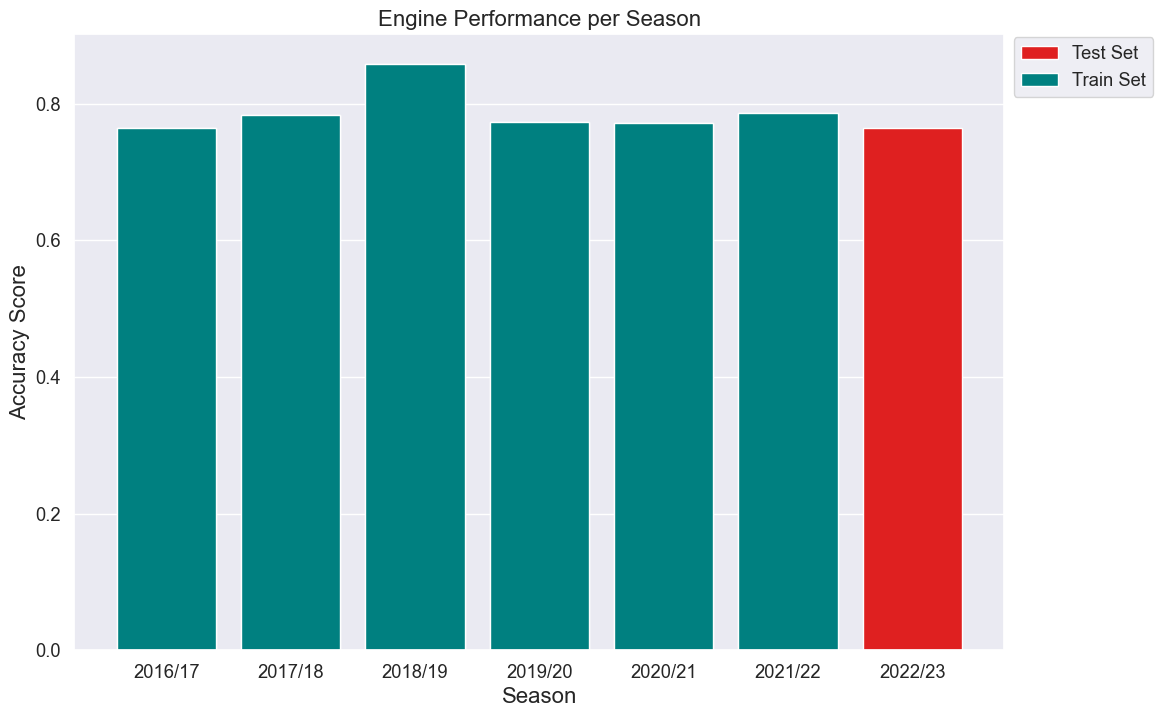

In [12]:
# Creating a list of seasons in ascending order
seasons = sorted(results_df.season.unique().tolist())

# Creating an empty list
accuracies = []

# Looping through each season
for season in seasons:
    # Extracting the ground truth labels based on high and very high confidence regions
    ground_truth = results_df.loc[(results_df.season == season) & (results_df.confidence.isin(values = ['High', 'Very High'])), 'ground_truth']
    
    # Extracting the predicted labels based on high and very high confidence regions
    prediction = results_df.loc[(results_df.season == season) & (results_df.confidence.isin(values = ['High', 'Very High'])), 'prediction']
    
    # Calculating the accuracy score of the engine
    accuracy = accuracy_score(y_true = ground_truth, y_pred = prediction)
    
    # Appending the accuracy to the list
    accuracies.append(accuracy)

# Visualizing the engine performance
sns.barplot(x = seasons, y = accuracies, label = 'Test Set', color = 'red')
plt.bar(x = seasons[:-1], height = accuracies[:-1], label = 'Train Set', color = 'teal')
plt.title(label = 'Engine Performance per Season', fontsize = 16)
plt.ylabel(ylabel = 'Accuracy Score', fontsize = 16)
plt.xlabel(xlabel = 'Season', fontsize = 16)
plt.legend(bbox_to_anchor = (1, 1.01), loc = 'upper left')
plt.show()

Let's calculate the **accuracy score** of the **Engine** for the train & test sets.

In [13]:
# Filtering ground truth and predictions based on High & Very High confidence intervals for the train set
y_train_pred = results_df.loc[(results_df.season != CURRENT_SEASON) & (results_df.confidence.isin(values = ['High', 'Very High'])), 'prediction']
y_train = results_df.loc[(results_df.season != CURRENT_SEASON) & (results_df.confidence.isin(values = ['High', 'Very High'])), 'ground_truth']

# Filtering ground truth and predictions based on High & Very High confidence intervals for the test set
y_test_pred = results_df.loc[(results_df.season == CURRENT_SEASON) & (results_df.confidence.isin(values = ['High', 'Very High'])), 'prediction']
y_test = results_df.loc[(results_df.season == CURRENT_SEASON) & (results_df.confidence.isin(values = ['High', 'Very High'])), 'ground_truth']

# Calculating the accuracy score of the Engine for the train & test sets
train_accuracy = accuracy_score(y_true = y_train, y_pred = y_train_pred)
test_accuracy = accuracy_score(y_true = y_test, y_pred = y_test_pred)

# Printing out the performance of the Engine for the train & test sets
print(f'Engine\'s accuracy on train set: {train_accuracy:.0%}')
print(f'Engine\'s accuracy on test set: {test_accuracy:.0%}')

Engine's accuracy on train set: 79%
Engine's accuracy on test set: 76%


In [14]:
# Calling the function to make predictions using shadow models
results_df = make_predictions(data_frame = df, use_shadow_models = True)

# Displaying the first five records
results_df.head()

,season,match_week,match_date,home_team,away_team,home_win,home_prediction,away_win,away_prediction,draw,draw_prediction,ground_truth,prediction,probability,confidence,bet,engine_output
0,2022/23,11,2022-10-16,Aston Villa,Chelsea,0,0,1,1,0,0,-1,-1,0.542456,Low,False,Probability of Chelsea defeating Aston Villa a...
1,2022/23,11,2022-10-16,Leeds,Arsenal,0,0,1,1,0,0,-1,-1,0.542412,Low,False,Probability of Arsenal defeating Leeds away fr...
2,2022/23,11,2022-10-16,Man Utd,Newcastle,0,0,0,0,1,0,0,1,0.666921,High,True,Probability of Man Utd beating Newcastle at ho...
3,2022/23,11,2022-10-16,Southampton,West Ham,0,0,0,0,1,0,0,-1,0.493056,Low,False,Probability of West Ham defeating Southampton ...
4,2022/23,11,2022-10-16,Liverpool,Man City,1,0,0,0,0,0,1,1,0.574463,Medium,False,Probability of Liverpool beating Man City at h...


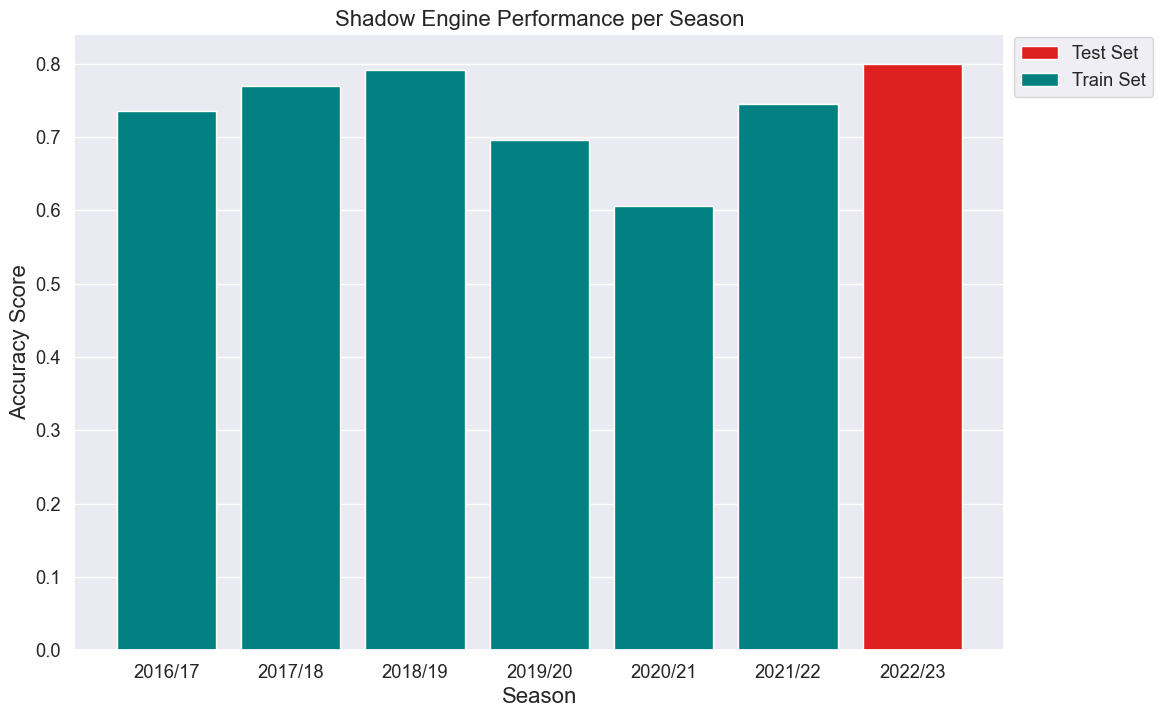

In [15]:
# Creating a list of seasons in ascending order
seasons = sorted(results_df.season.unique().tolist())

# Creating an empty list
accuracies = []

# Looping through each season
for season in seasons:
    # Extracting the ground truth labels based on high and very high confidence regions
    ground_truth = results_df.loc[(results_df.season == season) & (results_df.confidence.isin(values = ['High', 'Very High'])), 'ground_truth']
    
    # Extracting the predicted labels based on high and very high confidence regions
    prediction = results_df.loc[(results_df.season == season) & (results_df.confidence.isin(values = ['High', 'Very High'])), 'prediction']
    
    # Calculating the accuracy score of the engine
    accuracy = accuracy_score(y_true = ground_truth, y_pred = prediction)
    
    # Appending the accuracy to the list
    accuracies.append(accuracy)

# Visualizing the engine performance
sns.barplot(x = seasons, y = accuracies, label = 'Test Set', color = 'red')
plt.bar(x = seasons[:-1], height = accuracies[:-1], label = 'Train Set', color = 'teal')
plt.title(label = 'Shadow Engine Performance per Season', fontsize = 16)
plt.ylabel(ylabel = 'Accuracy Score', fontsize = 16)
plt.xlabel(xlabel = 'Season', fontsize = 16)
plt.legend(bbox_to_anchor = (1, 1.01), loc = 'upper left')
plt.show()

In [16]:
# Filtering ground truth and predictions based on High & Very High confidence intervals for the train set
y_train_pred = results_df.loc[(results_df.season != CURRENT_SEASON) & (results_df.confidence.isin(values = ['High', 'Very High'])), 'prediction']
y_train = results_df.loc[(results_df.season != CURRENT_SEASON) & (results_df.confidence.isin(values = ['High', 'Very High'])), 'ground_truth']

# Filtering ground truth and predictions based on High & Very High confidence intervals for the test set
y_test_pred = results_df.loc[(results_df.season == CURRENT_SEASON) & (results_df.confidence.isin(values = ['High', 'Very High'])), 'prediction']
y_test = results_df.loc[(results_df.season == CURRENT_SEASON) & (results_df.confidence.isin(values = ['High', 'Very High'])), 'ground_truth']

# Calculating the accuracy score of the Shadow Engine for the train & test sets
train_accuracy = accuracy_score(y_true = y_train, y_pred = y_train_pred)
test_accuracy = accuracy_score(y_true = y_test, y_pred = y_test_pred)

# Printing out the performance of the Shadow Engine for the train & test sets
print(f'Shadow Engine\'s accuracy on train set: {train_accuracy:.0%}')
print(f'Shadow Engine\'s accuracy on test set: {test_accuracy:.0%}')

Shadow Engine's accuracy on train set: 72%
Shadow Engine's accuracy on test set: 80%
